### Import dependecies and utilities

In [1]:
# !pip3 install tensorflow tensorflow-gpu opencv-python mediapipe sklearn matplotlib

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp

### Detection and drawing functions

In [2]:
# Variables from Mediapipe for detection and drawing
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
# detection(img, model): This function process an image and make predictions about what detects (hands, face, pose)
#     img: The image we want to process
#     model: The model that will make the predictions

def detection(img, model):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Color conversion to RGB
    img.flags.writeable = False
    results = model.process(img) # Image processing
    img.flags.writeable = True
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Back to original color (BGR)
    return img, results
    

In [4]:
# show_landmarks(img, results): This function show the conections and landmarks of face, hands and pose. Also adds styles.
#     img: The image we want to process
#     results: Results given by the predictor

def show_landmarks(img, results):
    mp_drawing.draw_landmarks(
        img, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
        mp_drawing.DrawingSpec(color=(0,0,255), thickness=1, circle_radius=1),
        mp_drawing.DrawingSpec(color=(10,255,0), thickness=1, circle_radius=1)
    )
    mp_drawing.draw_landmarks(
        img, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
         mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=1),
         mp_drawing.DrawingSpec(color=(234,232,24), thickness=2, circle_radius=2)
    )
    mp_drawing.draw_landmarks(
        img, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
         mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=1),
         mp_drawing.DrawingSpec(color=(228,19,206), thickness=2, circle_radius=2)
    )
    mp_drawing.draw_landmarks(
        img, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
         mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=1),
         mp_drawing.DrawingSpec(color=(228,19,206), thickness=2, circle_radius=2)
    )

### Webcam test

In [5]:

capture = cv2.VideoCapture(1)

if capture.isOpened() is False: print("Camera is not available")
    
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic: # Setting mediapipe model
    while capture.isOpened():
        
        # Read frames and show them
        _, frame = capture.read()
        
        # Model results prediction
        img, results = detection(frame, holistic)
        
        # Show landmarks
        show_landmarks(img, results)
        
        cv2.imshow("OpenCV video", img)

        if cv2.waitKey(1) == ord("q"):
            break
    capture.release()
    cv2.destroyAllWindows()


### Get landmarks

In [5]:
NUM_POSE_LANDMARKS = 33 * 4 # 33 landmarks. 3 coordinates and 1 visibility attribute per landmark
NUM_FACE_LANDMARKS = 468 * 3 # 468 landmarks. 3 coordinates per landmark
NUM_HAND_LANDMARKS = 21 * 3 # 21 landmarks. 3 coordinates per landmark
TOTAL_LANDMARKS = NUM_POSE_LANDMARKS + NUM_FACE_LANDMARKS + NUM_HAND_LANDMARKS * 2

In [6]:
'''TODO: Optimizar'''

def get_landmarks(results):
    
    # Face
    face = []
    if results.face_landmarks:
        for result in results.face_landmarks.landmark:
            landmark = [result.x, result.y, result.z]
            face.append(landmark)
        face = np.array(face).flatten()
    else:
        face = np.zeros(NUM_FACE_LANDMARKS)
    face = np.array(face).flatten()
    
    # Pose
    pose = []
    if results.pose_landmarks:
        for result in results.pose_landmarks.landmark:
            landmark = [result.x, result.y, result.z, result.visibility]
            pose.append(landmark)
        pose = np.array(pose).flatten()
    else:
        pose = np.zeros(NUM_POSE_LANDMARKS)
    pose = np.array(pose).flatten()
    
    #Left hand
    left_hand = []
    if results.left_hand_landmarks:
        for result in results.left_hand_landmarks.landmark:
            landmark = [result.x, result.y, result.z]
            left_hand.append(landmark)
    else:
        left_hand = np.zeros(NUM_HAND_LANDMARKS)
    left_hand = np.array(left_hand).flatten()
    
    # Right hand
    right_hand = []
    if results.right_hand_landmarks:
        for result in results.right_hand_landmarks.landmark:
            landmark = [result.x, result.y, result.z]
            right_hand.append(landmark)
    else:
        right_hand = np.zeros(NUM_HAND_LANDMARKS)
    right_hand = np.array(right_hand).flatten()
    
    # Return all landmarks concatenated
    return np.concatenate([face, pose, left_hand, right_hand])


### Setting up folders for datasets

#### Train

In [656]:

# # SOURCE_PATH = os.path.join("source")
# DATASET_PATH = os.path.join("train/dataset")
# signs = np.array(["hola", "gracias", "atencion"])
# # signs = np.array(["hola", "gracias", "atencion", "comoestas", "buenosdias", "bienvenidos"])
# # signs = np.array(["comoestas", "buenosdias", "bienvenidos"])

# '''Only used on Camera Version'''
# num_videos = 30
# len_videos = 30


#### Test

In [14]:
DATASET_PATH = os.path.join("test/dataset_D_8signs_60")
# signs = np.array(["hola", "gracias", "atencion"])
signs = np.array(["hola", "gracias", "atencion", "comoestas", "buenosdias", "bienvenidos", "porfavor", "adios"])
# signs = np.array(["comoestas", "buenosdias", "bienvenidos"])
# signs = np.array(["adios", "porfavor"])
# signs = np.array(["adios", "porfavor"])

'''Only used on Camera Version'''
num_videos = 60
len_videos = 30

#### Create folders for processed data

In [18]:
# import shutil

# '''Webcam Version'''
# try:
#     shutil.rmtree(DATASET_PATH)
# except Exception as e:
#     print("os.remove() failed: ", e.strerror)
    
for sign in signs:
    for video_index in range(num_videos):
        try:
            os.makedirs(os.path.join(DATASET_PATH, sign, str(video_index)))
        except:
            pass

'''Video File Version'''
# for sign in signs:
#     videos = os.listdir(os.path.join(SOURCE_PATH, sign))
#     for video_index, video in enumerate(videos):
#         try:
#             os.makedirs(os.path.join(DATASET_PATH, sign, str(video_index)))
#         except:
#             pass


'Video File Version'

### Code for data join

In [54]:
PATH1 = os.path.join("train/mama")
PATH2 = os.path.join("train/dataset_ABC_8signs")
signs = np.array(["hola", "gracias", "atencion", "comoestas", "buenosdias", "bienvenidos","adios", "porfavor"])
# signs = np.array(["hola", "gracias", "atencion"])
# signs = np.array(["adios", "porfavor"])

for sign in signs:
    videos = os.listdir(os.path.join(PATH2, sign))
    videos = list(map(int, videos))
    print(videos)
    nextname = max(videos)
    print(nextname)
    videos2 = os.listdir(os.path.join(PATH1, sign))
    videos2 = list(map(int, videos2))
    print(videos2)
    for video_index, video in enumerate(videos2):
        nextname += 1
        os.rename(os.path.join(PATH1, sign, str(video_index)), os.path.join(PATH1, sign, str(nextname)))
        
        

[0, 1, 10, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 11, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 6, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 8, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
119
[0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 6, 7, 8, 9]
[0, 1, 10, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 11, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49

FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado: 'train/mama\\adios\\0' -> 'train/mama\\adios\\120'

In [29]:
# Reset folder names
PATH = os.path.join("test/dataset_C_6signs")
# signs = np.array(["hola", "gracias", "atencion"])
# signs = np.array(["adios", "porfavor"])
signs = np.array(["hola", "gracias", "atencion", "comoestas", "buenosdias", "bienvenidos"])
for sign in signs:
    videos = os.listdir(os.path.join(PATH, sign))
    videos = list(map(int, videos))
    print(videos)
    for video_index in range(60):
        os.rename(os.path.join(PATH, sign, str(videos[video_index])), os.path.join(PATH, sign, str(video_index)))

[120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
[120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
[120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
[120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 1

### Create datasets

#### Camera Version

In [16]:
camera = cv2.VideoCapture(1)
if not camera.isOpened(): print("error")
while camera.isOpened():
    _, frame = camera.read()
    cv2.imshow("webcam",frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
camera.release()
cv2.destroyAllWindows()

In [19]:

camera = cv2.VideoCapture(1)

if camera.isOpened() is False: 
    print("Camera is not available.")
else:
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic: # Setting mediapipe model
        for sign in signs:
            for video in range(num_videos):
                for video_frame in range(len_videos):

                    # Read frames and show
                    _, frame = camera.read()

                    # Model results prediction
                    img, results = detection(frame, holistic)    

                    # Show landmarks
                    show_landmarks(img, results)

                    # Capture funtionality
                    if video_frame==0:
                        cv2.rectangle(img, (0,0), (640, 40), (255, 255, 255), -1)
                        cv2.putText(img, 'Comenzando captura de {} Video [{}]'
                                    .format(sign.upper(), str(video)), (3,30), cv2.FONT_HERSHEY_SIMPLEX, .75, (0,0,0), 1, cv2.LINE_AA)
                        
                        cv2.imshow('Sign Language Recognition', img)
                        cv2.waitKey(2000) # Wait 2sec
                    else:
                        cv2.imshow('Sign Language Recognition', img)

                    # Landmarks saving
                    all_landmarks = get_landmarks(results)
                    path = os.path.join(DATASET_PATH, sign, str(video), str(video_frame))
                    np.save(path, all_landmarks)

                    if cv2.waitKey(1) == ord('q'):
                        camera.release()
                        cv2.destroyAllWindows()
                        break
                        
                    
        camera.release()
        cv2.destroyAllWindows()


#### Video Files Version

In [15]:
'''
frames_length = []
NUM_POSE_LANDMARKS = 33 * 4 # 33 landmarks. 3 coordinates and 1 visibility attribute per landmark
NUM_FACE_LANDMARKS = 468 * 3 # 468 landmarks. 3 coordinates per landmark
NUM_HAND_LANDMARKS = 21 * 3 # 21 landmarks. 3 coordinates per landmark
TOTAL_LANDMARKS = NUM_POSE_LANDMARKS + NUM_FACE_LANDMARKS + NUM_HAND_LANDMARKS * 2

for sign in signs:
    videos = os.listdir(os.path.join(SOURCE_PATH, sign))
    print(videos)
    for video_index, video in enumerate(videos):
        video_path = os.path.join(SOURCE_PATH, sign, video)
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames_length.append(frame_count)

MAX_FRAME_LENGTH = max(frames_length)
print(MAX_FRAME_LENGTH)


frame_time = 1
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic: # Setting mediapipe model
    for sign in signs:
        videos = os.listdir(os.path.join(SOURCE_PATH, sign))
        for video_index, video in enumerate(videos):
            video_path = os.path.join(SOURCE_PATH, sign, video)
            cap = cv2.VideoCapture(video_path)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            print(frame_count)
            for video_frame in range(MAX_FRAME_LENGTH):
                # Read frames and show
                ret, frame = cap.read()
                
                if not ret:
                    zero_landmarks = [0 for x in range(TOTAL_LANDMARKS)]
                    path = os.path.join(DATASET_PATH, sign, str(video_index), str(video_frame))
                    np.save(path, zero_landmarks)
                    continue

                # Model results prediction
                img, results = detection(frame, holistic)    

                # Show landmarks
                show_landmarks(img, results)

                # Capture funtionality
                if video_frame == 0:
                    cv2.putText(img, 'Comenzando captura', (150,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (60,35,239), 4, cv2.LINE_AA)
                    cv2.putText(img, 'Capturando frames para {} - Video [{}]'
                                .format(sign.upper(), video), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (60,35,239), 1, cv2.LINE_AA)
                    cv2.imshow('Sign Language Recognition', img)
                    cv2.waitKey(2000) # Wait 2sec
                else:
                    cv2.putText(img, 'Capturando frames para {} - Video [{}]'
                                .format(sign.upper(), video), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (60,35,239), 1, cv2.LINE_AA)
                    cv2.imshow('Sign Language Recognition', img)

                # Landmarks saving
                all_landmarks = get_landmarks(results)
                path = os.path.join(DATASET_PATH, sign, str(video_index), str(video_frame))
                np.save(path, all_landmarks)

                if cv2.waitKey(frame_time) == ord('q'):
                    break
    cap.release()
    cv2.destroyAllWindows()
'''

"\nframes_length = []\nNUM_POSE_LANDMARKS = 33 * 4 # 33 landmarks. 3 coordinates and 1 visibility attribute per landmark\nNUM_FACE_LANDMARKS = 468 * 3 # 468 landmarks. 3 coordinates per landmark\nNUM_HAND_LANDMARKS = 21 * 3 # 21 landmarks. 3 coordinates per landmark\nTOTAL_LANDMARKS = NUM_POSE_LANDMARKS + NUM_FACE_LANDMARKS + NUM_HAND_LANDMARKS * 2\n\nfor sign in signs:\n    videos = os.listdir(os.path.join(SOURCE_PATH, sign))\n    print(videos)\n    for video_index, video in enumerate(videos):\n        video_path = os.path.join(SOURCE_PATH, sign, video)\n        cap = cv2.VideoCapture(video_path)\n        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))\n        frames_length.append(frame_count)\n\nMAX_FRAME_LENGTH = max(frames_length)\nprint(MAX_FRAME_LENGTH)\n\n\nframe_time = 1\nwith mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic: # Setting mediapipe model\n    for sign in signs:\n        videos = os.listdir(os.path.join(SOURCE_PATH, 

### Get data

In [16]:
# videos = []
# labels = []
# DATASET_PATH = "dataset_fran_3signs"

# '''Webcam Version'''
# for sign in signs:
#     for video in range(num_videos):
#         video_aux = []
#         for frame in range(len_videos):
#             frame_aux = np.load(os.path.join(DATASET_PATH, sign, str(video), "{}.npy".format(frame)))
#             video_aux.append(frame_aux)
#         videos.append(video_aux)
#         labels.append(label_map[sign])

'''Video File Version'''
# for sign in signs:
#     videos_list = os.listdir(os.path.join(DATASET_PATH, sign))
#     for video in videos_list:
#         video_aux = []
#         frames = os.listdir(os.path.join(DATASET_PATH, sign, video))
#         for frame in frames:
#             frame_aux = np.load(os.path.join(DATASET_PATH, sign, str(video), frame))
#             video_aux.append(frame_aux)
#         videos.append(video_aux)
#         labels.append(label_map[sign])


'Video File Version'

In [17]:
# NUM_POSE_LANDMARKS = 33 * 4 # 33 landmarks. 3 coordinates and 1 visibility attribute per landmark
# NUM_FACE_LANDMARKS = 468 * 3 # 468 landmarks. 3 coordinates per landmark
# NUM_HAND_LANDMARKS = 21 * 3 # 21 landmarks. 3 coordinates per landmark
# TOTAL_LANDMARKS = NUM_POSE_LANDMARKS + NUM_FACE_LANDMARKS + NUM_HAND_LANDMARKS * 2

In [18]:
# X = np.array(videos)
# y = to_categorical(np.array(labels)).astype(int)

In [19]:
# num_videos = X.shape[0]
# num_videos

## LSTM

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

### 3 signs model (hola, gracias, atencion)

In [8]:
DATASET_PATH = os.path.join("train/dataset_AB_3signs")
signs = np.array(["hola", "gracias", "atencion"])

# '''Only used on Camera Version'''
num_videos = 60
len_videos = 30

In [9]:
label_map = {label:num for num, label in enumerate(signs)}
label_map

{'hola': 0, 'gracias': 1, 'atencion': 2}

In [44]:
videos = []
labels = []

'''Webcam Version'''
for sign in signs:
    for video in range(num_videos):
        video_aux = []
        for frame in range(len_videos):
            frame_aux = np.load(os.path.join(DATASET_PATH, sign, str(video), "{}.npy".format(frame)))
            video_aux.append(frame_aux)
        videos.append(video_aux)
        labels.append(label_map[sign])

In [45]:
X = np.array(videos)
y = to_categorical(np.array(labels)).astype(int)

In [630]:
X

array([[[ 1.16294414e-01,  4.30788070e-01, -1.90810021e-02, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 6.08630419e-01,  1.71940327e-01, -1.20010711e-02, ...,
          4.27423298e-01,  9.58247006e-01,  3.79228801e-03],
        [ 6.09406829e-01,  1.75046369e-01, -1.27705717e-02, ...,
          4.32061821e-01,  9.63108778e-01, -2.27850513e-03],
        ...,
        [ 6.50074124e-01,  2.03314647e-01, -1.12936180e-02, ...,
          2.91426361e-01,  6.89539015e-01, -3.63221578e-02],
        [ 6.45308256e-01,  2.00944245e-01, -1.15123093e-02, ...,
          3.39483261e-01,  8.39450896e-01, -1.27839288e-02],
        [ 6.40301168e-01,  1.97450802e-01, -1.23632140e-02, ...,
          3.80822480e-01,  9.12280500e-01,  5.05531533e-03]],

       [[ 6.33869052e-01,  1.95155516e-01, -1.21707609e-02, ...,
          4.12809849e-01,  9.37136471e-01,  8.89710616e-03],
        [ 5.48511028e-01,  1.82493463e-01, -1.11484909e-02, ...,
          3.51136088e-01,  9.45368230e

In [29]:
print(X.shape)
print(y.shape)

(180, 30, 1662)
(180, 3)


In [62]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [12]:
logs_path = os.path.join('logs/3signs_AB_3')
tensorboard = TensorBoard(log_dir=logs_path)


In [11]:
output = signs.shape[0]
output

3

In [8]:
# del model_3signs
model_3signs = Sequential()
model_3signs.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(len_videos,TOTAL_LANDMARKS)))
model_3signs.add(LSTM(32, return_sequences=False, activation='relu'))
model_3signs.add(Dense(64, activation='relu'))
model_3signs.add(Dropout(0.2))
model_3signs.add(Dense(32, activation='relu'))
model_3signs.add(Dense(output, activation='softmax'))

# del model_3signs
# model_3signs = Sequential()
# model_3signs.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(len_videos,TOTAL_LANDMARKS)))
# model_3signs.add(LSTM(128, return_sequences=True, activation='relu'))
# model_3signs.add(LSTM(64, return_sequences=False, activation='relu'))
# model_3signs.add(Dense(64, activation='relu'))
# model_3signs.add(Dense(32, activation='relu'))
# model_3signs.add(Dense(output, activation='softmax'))

model_3signs.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


NameError: name 'len_videos' is not defined

In [ ]:
'''Loading model'''
# model_3signs.load_weights('model_3signs.h5')

In [51]:
model_3signs.fit(X, y, epochs=4000, callbacks=[tensorboard], shuffle=True)


Epoch 1/4000
6/6 [==============================] - 2s 39ms/step - loss: 2.0068 - categorical_accuracy: 0.3556
Epoch 2/4000
6/6 [==============================] - 0s 35ms/step - loss: 1.3869 - categorical_accuracy: 0.3611
Epoch 3/4000
6/6 [==============================] - 0s 36ms/step - loss: 1.1053 - categorical_accuracy: 0.3056
Epoch 4/4000
6/6 [==============================] - 0s 35ms/step - loss: 1.1123 - categorical_accuracy: 0.3444
Epoch 5/4000
6/6 [==============================] - 0s 35ms/step - loss: 1.0945 - categorical_accuracy: 0.3444
Epoch 6/4000
6/6 [==============================] - 0s 39ms/step - loss: 1.0995 - categorical_accuracy: 0.3444
Epoch 7/4000
6/6 [==============================] - 0s 36ms/step - loss: 1.0922 - categorical_accuracy: 0.4278
Epoch 8/4000
6/6 [==============================] - 0s 38ms/step - loss: 1.0979 - categorical_accuracy: 0.3778
Epoch 9/4000
6/6 [==============================] - 0s 35ms/step - loss: 1.0755 - categorical_accuracy: 0.4500
E

6/6 [==============================] - 0s 36ms/step - loss: 0.0799 - categorical_accuracy: 0.9889
Epoch 147/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0743 - categorical_accuracy: 0.9889
Epoch 148/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0529 - categorical_accuracy: 0.9944
Epoch 149/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0524 - categorical_accuracy: 0.9944
Epoch 150/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0557 - categorical_accuracy: 0.9944
Epoch 151/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0493 - categorical_accuracy: 0.9944
Epoch 152/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0449 - categorical_accuracy: 0.9944
Epoch 153/4000
6/6 [==============================] - 0s 53ms/step - loss: 0.0461 - categorical_accuracy: 0.9944
Epoch 154/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0544 - categorical_accuracy: 0.994

6/6 [==============================] - 0s 41ms/step - loss: 0.1062 - categorical_accuracy: 0.9722
Epoch 291/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0862 - categorical_accuracy: 0.9722
Epoch 292/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.1888 - categorical_accuracy: 0.9278
Epoch 293/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.1267 - categorical_accuracy: 0.9667
Epoch 294/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0681 - categorical_accuracy: 0.9833
Epoch 295/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.1741 - categorical_accuracy: 0.9389
Epoch 296/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0716 - categorical_accuracy: 0.9889
Epoch 297/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0739 - categorical_accuracy: 0.9778
Epoch 298/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0501 - categorical_accuracy: 0.994

6/6 [==============================] - 0s 41ms/step - loss: 0.5798 - categorical_accuracy: 0.9111
Epoch 435/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.3653 - categorical_accuracy: 0.9111
Epoch 436/4000
6/6 [==============================] - 0s 38ms/step - loss: 1.0001 - categorical_accuracy: 0.7056
Epoch 437/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.4701 - categorical_accuracy: 0.7889
Epoch 438/4000
6/6 [==============================] - 0s 41ms/step - loss: 0.4971 - categorical_accuracy: 0.7389
Epoch 439/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.3812 - categorical_accuracy: 0.8889
Epoch 440/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.2329 - categorical_accuracy: 0.9611
Epoch 441/4000
6/6 [==============================] - 0s 45ms/step - loss: 0.1543 - categorical_accuracy: 0.9556
Epoch 442/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.1344 - categorical_accuracy: 0.972

6/6 [==============================] - 0s 38ms/step - loss: 0.0247 - categorical_accuracy: 0.9944
Epoch 579/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0254 - categorical_accuracy: 0.9944
Epoch 580/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0178 - categorical_accuracy: 0.9944
Epoch 581/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0245 - categorical_accuracy: 0.9944
Epoch 582/4000
6/6 [==============================] - 0s 52ms/step - loss: 0.0285 - categorical_accuracy: 0.9944
Epoch 583/4000
6/6 [==============================] - 0s 41ms/step - loss: 0.0300 - categorical_accuracy: 0.9944
Epoch 584/4000
6/6 [==============================] - 0s 41ms/step - loss: 0.0228 - categorical_accuracy: 0.9944
Epoch 585/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0202 - categorical_accuracy: 0.9944
Epoch 586/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0233 - categorical_accuracy: 0.994

6/6 [==============================] - 0s 36ms/step - loss: 0.0269 - categorical_accuracy: 0.9944
Epoch 723/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0270 - categorical_accuracy: 0.9944
Epoch 724/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0270 - categorical_accuracy: 0.9944
Epoch 725/4000
6/6 [==============================] - 0s 41ms/step - loss: 0.0275 - categorical_accuracy: 0.9944
Epoch 726/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0231 - categorical_accuracy: 0.9944
Epoch 727/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0190 - categorical_accuracy: 0.9944
Epoch 728/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0257 - categorical_accuracy: 0.9944
Epoch 729/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0271 - categorical_accuracy: 0.9944
Epoch 730/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0179 - categorical_accuracy: 0.994

6/6 [==============================] - 0s 42ms/step - loss: 0.0225 - categorical_accuracy: 0.9944
Epoch 867/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0168 - categorical_accuracy: 0.9944
Epoch 868/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0165 - categorical_accuracy: 0.9944
Epoch 869/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0131 - categorical_accuracy: 0.9944
Epoch 870/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0144 - categorical_accuracy: 0.9944
Epoch 871/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0177 - categorical_accuracy: 0.9944
Epoch 872/4000
6/6 [==============================] - 0s 44ms/step - loss: 0.0169 - categorical_accuracy: 0.9944
Epoch 873/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0178 - categorical_accuracy: 0.9944
Epoch 874/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0935 - categorical_accuracy: 0.983

6/6 [==============================] - 0s 40ms/step - loss: 0.0162 - categorical_accuracy: 0.9944
Epoch 1011/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0137 - categorical_accuracy: 0.9944
Epoch 1012/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0168 - categorical_accuracy: 0.9944
Epoch 1013/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0138 - categorical_accuracy: 0.9944
Epoch 1014/4000
6/6 [==============================] - 0s 41ms/step - loss: 0.0157 - categorical_accuracy: 0.9944
Epoch 1015/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0208 - categorical_accuracy: 0.9944
Epoch 1016/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0185 - categorical_accuracy: 0.9944
Epoch 1017/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0212 - categorical_accuracy: 0.9944
Epoch 1018/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0243 - categorical_accurac

6/6 [==============================] - 0s 39ms/step - loss: 0.0267 - categorical_accuracy: 0.9944
Epoch 1083/4000
6/6 [==============================] - 0s 41ms/step - loss: 0.0312 - categorical_accuracy: 0.9944
Epoch 1084/4000
6/6 [==============================] - 0s 46ms/step - loss: 0.0236 - categorical_accuracy: 0.9944
Epoch 1085/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0204 - categorical_accuracy: 0.9944
Epoch 1086/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0161 - categorical_accuracy: 0.9944
Epoch 1087/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0185 - categorical_accuracy: 0.9944
Epoch 1088/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0092 - categorical_accuracy: 0.9944
Epoch 1089/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0177 - categorical_accuracy: 0.9944
Epoch 1090/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0117 - categorical_accurac

6/6 [==============================] - 0s 36ms/step - loss: 0.3249 - categorical_accuracy: 0.8667
Epoch 1155/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.3158 - categorical_accuracy: 0.8722
Epoch 1156/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.2912 - categorical_accuracy: 0.8722
Epoch 1157/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.2890 - categorical_accuracy: 0.8833
Epoch 1158/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.2720 - categorical_accuracy: 0.8833
Epoch 1159/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.3014 - categorical_accuracy: 0.8833
Epoch 1160/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.2497 - categorical_accuracy: 0.8833
Epoch 1161/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.2768 - categorical_accuracy: 0.8944
Epoch 1162/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.2101 - categorical_accurac

6/6 [==============================] - 0s 36ms/step - loss: 0.0611 - categorical_accuracy: 0.9889
Epoch 1227/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0440 - categorical_accuracy: 0.9944
Epoch 1228/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0439 - categorical_accuracy: 0.9944
Epoch 1229/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0527 - categorical_accuracy: 0.9889
Epoch 1230/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0518 - categorical_accuracy: 0.9944
Epoch 1231/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0421 - categorical_accuracy: 0.9944
Epoch 1232/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0572 - categorical_accuracy: 0.9833
Epoch 1233/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0637 - categorical_accuracy: 0.9778
Epoch 1234/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0940 - categorical_accurac

6/6 [==============================] - 0s 46ms/step - loss: 0.0395 - categorical_accuracy: 0.9944
Epoch 1299/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0351 - categorical_accuracy: 0.9944
Epoch 1300/4000
6/6 [==============================] - 0s 52ms/step - loss: 0.0257 - categorical_accuracy: 0.9944
Epoch 1301/4000
6/6 [==============================] - 0s 48ms/step - loss: 0.0507 - categorical_accuracy: 0.9889
Epoch 1302/4000
6/6 [==============================] - 0s 45ms/step - loss: 0.0401 - categorical_accuracy: 0.9944
Epoch 1303/4000
6/6 [==============================] - 0s 45ms/step - loss: 0.0329 - categorical_accuracy: 0.9944
Epoch 1304/4000
6/6 [==============================] - 0s 46ms/step - loss: 0.0423 - categorical_accuracy: 0.9944
Epoch 1305/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0445 - categorical_accuracy: 0.9889
Epoch 1306/4000
6/6 [==============================] - 0s 44ms/step - loss: 0.0439 - categorical_accurac

6/6 [==============================] - 0s 48ms/step - loss: 0.0247 - categorical_accuracy: 0.9944
Epoch 1371/4000
6/6 [==============================] - 0s 51ms/step - loss: 0.0282 - categorical_accuracy: 0.9944
Epoch 1372/4000
6/6 [==============================] - 0s 51ms/step - loss: 0.0245 - categorical_accuracy: 0.9944
Epoch 1373/4000
6/6 [==============================] - 0s 52ms/step - loss: 0.0254 - categorical_accuracy: 0.9944
Epoch 1374/4000
6/6 [==============================] - 0s 48ms/step - loss: 0.0273 - categorical_accuracy: 0.9944
Epoch 1375/4000
6/6 [==============================] - 0s 43ms/step - loss: 0.0308 - categorical_accuracy: 0.9944
Epoch 1376/4000
6/6 [==============================] - 0s 45ms/step - loss: 0.0310 - categorical_accuracy: 0.9944
Epoch 1377/4000
6/6 [==============================] - 0s 44ms/step - loss: 0.0279 - categorical_accuracy: 0.9944
Epoch 1378/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0267 - categorical_accurac

6/6 [==============================] - 0s 36ms/step - loss: 0.0244 - categorical_accuracy: 0.9944
Epoch 1443/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0243 - categorical_accuracy: 0.9944
Epoch 1444/4000
6/6 [==============================] - 0s 42ms/step - loss: 0.0187 - categorical_accuracy: 0.9944
Epoch 1445/4000
6/6 [==============================] - 0s 44ms/step - loss: 0.0223 - categorical_accuracy: 0.9944
Epoch 1446/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0290 - categorical_accuracy: 0.9889
Epoch 1447/4000
6/6 [==============================] - 0s 48ms/step - loss: 0.0398 - categorical_accuracy: 0.9889
Epoch 1448/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0351 - categorical_accuracy: 0.9889
Epoch 1449/4000
6/6 [==============================] - 0s 43ms/step - loss: 4.1203 - categorical_accuracy: 0.8389
Epoch 1450/4000
6/6 [==============================] - 0s 37ms/step - loss: 13.5348 - categorical_accura

Epoch 1514/4000
6/6 [==============================] - 0s 35ms/step - loss: 1.0998 - categorical_accuracy: 0.3500
Epoch 1515/4000
6/6 [==============================] - 0s 35ms/step - loss: 1.1004 - categorical_accuracy: 0.3667
Epoch 1516/4000
6/6 [==============================] - 0s 35ms/step - loss: 1.1006 - categorical_accuracy: 0.3556
Epoch 1517/4000
6/6 [==============================] - 0s 37ms/step - loss: 1.1007 - categorical_accuracy: 0.3111
Epoch 1518/4000
6/6 [==============================] - 0s 35ms/step - loss: 1.0980 - categorical_accuracy: 0.3111
Epoch 1519/4000
6/6 [==============================] - 0s 35ms/step - loss: 1.0979 - categorical_accuracy: 0.3278
Epoch 1520/4000
6/6 [==============================] - 0s 35ms/step - loss: 1.0997 - categorical_accuracy: 0.3444
Epoch 1521/4000
6/6 [==============================] - 0s 35ms/step - loss: 1.0940 - categorical_accuracy: 0.3611
Epoch 1522/4000
6/6 [==============================] - 0s 36ms/step - loss: 1.0955 - cat

6/6 [==============================] - 0s 37ms/step - loss: 1.0872 - categorical_accuracy: 0.3778
Epoch 1658/4000
6/6 [==============================] - 0s 43ms/step - loss: 1.0922 - categorical_accuracy: 0.3889
Epoch 1659/4000
6/6 [==============================] - 0s 36ms/step - loss: 1.1037 - categorical_accuracy: 0.3667
Epoch 1660/4000
6/6 [==============================] - 0s 36ms/step - loss: 1.0826 - categorical_accuracy: 0.4056
Epoch 1661/4000
6/6 [==============================] - 0s 35ms/step - loss: 1.0924 - categorical_accuracy: 0.3722
Epoch 1662/4000
6/6 [==============================] - 0s 36ms/step - loss: 1.0859 - categorical_accuracy: 0.3778
Epoch 1663/4000
6/6 [==============================] - 0s 37ms/step - loss: 1.0852 - categorical_accuracy: 0.3833
Epoch 1664/4000
6/6 [==============================] - 0s 36ms/step - loss: 1.0937 - categorical_accuracy: 0.3889
Epoch 1665/4000
6/6 [==============================] - 0s 36ms/step - loss: 1.0973 - categorical_accurac

6/6 [==============================] - 0s 37ms/step - loss: 1.0778 - categorical_accuracy: 0.3556
Epoch 1730/4000
6/6 [==============================] - 0s 36ms/step - loss: 1.0780 - categorical_accuracy: 0.3778
Epoch 1731/4000
6/6 [==============================] - 0s 38ms/step - loss: 1.0730 - categorical_accuracy: 0.4500
Epoch 1732/4000
6/6 [==============================] - 0s 35ms/step - loss: 1.0595 - categorical_accuracy: 0.4833
Epoch 1733/4000
6/6 [==============================] - 0s 36ms/step - loss: 1.0591 - categorical_accuracy: 0.4444
Epoch 1734/4000
6/6 [==============================] - 0s 37ms/step - loss: 1.0510 - categorical_accuracy: 0.4556
Epoch 1735/4000
6/6 [==============================] - 0s 36ms/step - loss: 1.0142 - categorical_accuracy: 0.5667
Epoch 1736/4000
6/6 [==============================] - 0s 37ms/step - loss: 1.0065 - categorical_accuracy: 0.5889
Epoch 1737/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.9937 - categorical_accurac

6/6 [==============================] - 0s 43ms/step - loss: 0.3854 - categorical_accuracy: 0.8500
Epoch 1802/4000
6/6 [==============================] - 0s 42ms/step - loss: 0.4210 - categorical_accuracy: 0.8722
Epoch 1803/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.4039 - categorical_accuracy: 0.8222
Epoch 1804/4000
6/6 [==============================] - 0s 43ms/step - loss: 0.4193 - categorical_accuracy: 0.8556
Epoch 1805/4000
6/6 [==============================] - 0s 44ms/step - loss: 0.3933 - categorical_accuracy: 0.8333
Epoch 1806/4000
6/6 [==============================] - 0s 44ms/step - loss: 0.3806 - categorical_accuracy: 0.8667
Epoch 1807/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.3854 - categorical_accuracy: 0.8333
Epoch 1808/4000
6/6 [==============================] - 0s 43ms/step - loss: 0.4030 - categorical_accuracy: 0.8444
Epoch 1809/4000
6/6 [==============================] - 0s 45ms/step - loss: 0.3613 - categorical_accurac

6/6 [==============================] - 0s 46ms/step - loss: 0.1438 - categorical_accuracy: 0.9389
Epoch 1874/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.1620 - categorical_accuracy: 0.9500
Epoch 1875/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.2537 - categorical_accuracy: 0.9111
Epoch 1876/4000
6/6 [==============================] - 0s 47ms/step - loss: 0.1825 - categorical_accuracy: 0.9333
Epoch 1877/4000
6/6 [==============================] - 0s 47ms/step - loss: 0.1383 - categorical_accuracy: 0.9556
Epoch 1878/4000
6/6 [==============================] - 0s 44ms/step - loss: 0.1640 - categorical_accuracy: 0.9500
Epoch 1879/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.2397 - categorical_accuracy: 0.9333
Epoch 1880/4000
6/6 [==============================] - 0s 42ms/step - loss: 0.1323 - categorical_accuracy: 0.9722
Epoch 1881/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.2065 - categorical_accurac

6/6 [==============================] - 0s 36ms/step - loss: 0.2191 - categorical_accuracy: 0.9167
Epoch 1946/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.2075 - categorical_accuracy: 0.9333
Epoch 1947/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.1682 - categorical_accuracy: 0.9500
Epoch 1948/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.1854 - categorical_accuracy: 0.9444
Epoch 1949/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.1775 - categorical_accuracy: 0.9333
Epoch 1950/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.1450 - categorical_accuracy: 0.9667
Epoch 1951/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.1562 - categorical_accuracy: 0.9556
Epoch 1952/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.1617 - categorical_accuracy: 0.9444
Epoch 1953/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.1372 - categorical_accurac

6/6 [==============================] - 0s 41ms/step - loss: 0.0837 - categorical_accuracy: 0.9722
Epoch 2018/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.1067 - categorical_accuracy: 0.9667
Epoch 2019/4000
6/6 [==============================] - 0s 53ms/step - loss: 0.0902 - categorical_accuracy: 0.9722
Epoch 2020/4000
6/6 [==============================] - 0s 44ms/step - loss: 0.0915 - categorical_accuracy: 0.9778
Epoch 2021/4000
6/6 [==============================] - 0s 52ms/step - loss: 0.0702 - categorical_accuracy: 0.9833
Epoch 2022/4000
6/6 [==============================] - 0s 50ms/step - loss: 0.0688 - categorical_accuracy: 0.9722
Epoch 2023/4000
6/6 [==============================] - 0s 47ms/step - loss: 0.0859 - categorical_accuracy: 0.9778
Epoch 2024/4000
6/6 [==============================] - 0s 51ms/step - loss: 0.0679 - categorical_accuracy: 0.9833
Epoch 2025/4000
6/6 [==============================] - 0s 51ms/step - loss: 0.0855 - categorical_accurac

6/6 [==============================] - 0s 39ms/step - loss: 0.1084 - categorical_accuracy: 0.9722
Epoch 2090/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.1063 - categorical_accuracy: 0.9556
Epoch 2091/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.1313 - categorical_accuracy: 0.9556
Epoch 2092/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.2613 - categorical_accuracy: 0.9111
Epoch 2093/4000
6/6 [==============================] - 0s 42ms/step - loss: 0.1412 - categorical_accuracy: 0.9500
Epoch 2094/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.1829 - categorical_accuracy: 0.9167
Epoch 2095/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.1220 - categorical_accuracy: 0.9500
Epoch 2096/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.1016 - categorical_accuracy: 0.9667
Epoch 2097/4000
6/6 [==============================] - 0s 49ms/step - loss: 0.0668 - categorical_accurac

6/6 [==============================] - 0s 56ms/step - loss: 0.0688 - categorical_accuracy: 0.9778
Epoch 2162/4000
6/6 [==============================] - 0s 51ms/step - loss: 0.0737 - categorical_accuracy: 0.9833
Epoch 2163/4000
6/6 [==============================] - 0s 42ms/step - loss: 0.2773 - categorical_accuracy: 0.9111
Epoch 2164/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0795 - categorical_accuracy: 0.9667
Epoch 2165/4000
6/6 [==============================] - 0s 45ms/step - loss: 0.0912 - categorical_accuracy: 0.9778
Epoch 2166/4000
6/6 [==============================] - 0s 50ms/step - loss: 0.0471 - categorical_accuracy: 0.9944
Epoch 2167/4000
6/6 [==============================] - 0s 52ms/step - loss: 0.1226 - categorical_accuracy: 0.9722
Epoch 2168/4000
6/6 [==============================] - 0s 45ms/step - loss: 0.1485 - categorical_accuracy: 0.9611
Epoch 2169/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.1090 - categorical_accurac

6/6 [==============================] - 0s 37ms/step - loss: 0.0284 - categorical_accuracy: 0.9944
Epoch 2234/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0316 - categorical_accuracy: 0.9944
Epoch 2235/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0274 - categorical_accuracy: 0.9944
Epoch 2236/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0263 - categorical_accuracy: 0.9944
Epoch 2237/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0251 - categorical_accuracy: 0.9944
Epoch 2238/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0330 - categorical_accuracy: 0.9944
Epoch 2239/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0299 - categorical_accuracy: 0.9944
Epoch 2240/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0255 - categorical_accuracy: 0.9944
Epoch 2241/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0273 - categorical_accurac

6/6 [==============================] - 0s 56ms/step - loss: 0.0343 - categorical_accuracy: 0.9944
Epoch 2306/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0276 - categorical_accuracy: 0.9944
Epoch 2307/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0267 - categorical_accuracy: 0.9944
Epoch 2308/4000
6/6 [==============================] - 0s 52ms/step - loss: 0.0291 - categorical_accuracy: 0.9944
Epoch 2309/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0282 - categorical_accuracy: 0.9944
Epoch 2310/4000
6/6 [==============================] - 0s 48ms/step - loss: 0.0299 - categorical_accuracy: 0.9944
Epoch 2311/4000
6/6 [==============================] - 0s 60ms/step - loss: 0.0345 - categorical_accuracy: 0.9944
Epoch 2312/4000
6/6 [==============================] - 0s 58ms/step - loss: 0.0339 - categorical_accuracy: 0.9889
Epoch 2313/4000
6/6 [==============================] - 0s 69ms/step - loss: 0.0295 - categorical_accurac

6/6 [==============================] - 0s 36ms/step - loss: 0.0492 - categorical_accuracy: 0.9833
Epoch 2378/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0999 - categorical_accuracy: 0.9556
Epoch 2379/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0904 - categorical_accuracy: 0.9722
Epoch 2380/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0539 - categorical_accuracy: 0.9833
Epoch 2381/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0468 - categorical_accuracy: 0.9889
Epoch 2382/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0946 - categorical_accuracy: 0.9611
Epoch 2383/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.1998 - categorical_accuracy: 0.9389
Epoch 2384/4000
6/6 [==============================] - 0s 34ms/step - loss: 0.1656 - categorical_accuracy: 0.9556
Epoch 2385/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.1778 - categorical_accurac

6/6 [==============================] - 0s 36ms/step - loss: 0.0225 - categorical_accuracy: 0.9944
Epoch 2450/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0226 - categorical_accuracy: 0.9944
Epoch 2451/4000
6/6 [==============================] - 0s 44ms/step - loss: 0.0226 - categorical_accuracy: 0.9944
Epoch 2452/4000
6/6 [==============================] - 0s 42ms/step - loss: 0.0205 - categorical_accuracy: 0.9944
Epoch 2453/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0185 - categorical_accuracy: 0.9944
Epoch 2454/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0199 - categorical_accuracy: 0.9944
Epoch 2455/4000
6/6 [==============================] - 0s 47ms/step - loss: 0.0196 - categorical_accuracy: 0.9944
Epoch 2456/4000
6/6 [==============================] - 0s 50ms/step - loss: 0.0231 - categorical_accuracy: 0.9944
Epoch 2457/4000
6/6 [==============================] - 0s 50ms/step - loss: 0.0203 - categorical_accurac

6/6 [==============================] - 0s 36ms/step - loss: 0.0494 - categorical_accuracy: 0.9833
Epoch 2522/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0486 - categorical_accuracy: 0.9778
Epoch 2523/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0316 - categorical_accuracy: 0.9889
Epoch 2524/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0363 - categorical_accuracy: 0.9833
Epoch 2525/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0394 - categorical_accuracy: 0.9889
Epoch 2526/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.1108 - categorical_accuracy: 0.9722
Epoch 2527/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.1780 - categorical_accuracy: 0.9389
Epoch 2528/4000
6/6 [==============================] - 0s 42ms/step - loss: 0.1262 - categorical_accuracy: 0.9556
Epoch 2529/4000
6/6 [==============================] - 0s 43ms/step - loss: 0.0716 - categorical_accurac

6/6 [==============================] - 0s 39ms/step - loss: 0.0172 - categorical_accuracy: 0.9944
Epoch 2594/4000
6/6 [==============================] - 0s 41ms/step - loss: 0.0167 - categorical_accuracy: 0.9944
Epoch 2595/4000
6/6 [==============================] - 0s 43ms/step - loss: 0.0165 - categorical_accuracy: 0.9944
Epoch 2596/4000
6/6 [==============================] - 0s 42ms/step - loss: 0.0173 - categorical_accuracy: 0.9944
Epoch 2597/4000
6/6 [==============================] - 0s 42ms/step - loss: 0.0195 - categorical_accuracy: 0.9944
Epoch 2598/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0214 - categorical_accuracy: 0.9944
Epoch 2599/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0248 - categorical_accuracy: 0.9944
Epoch 2600/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0240 - categorical_accuracy: 0.9944
Epoch 2601/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0255 - categorical_accurac

6/6 [==============================] - 0s 35ms/step - loss: 0.0659 - categorical_accuracy: 0.9889
Epoch 2666/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0459 - categorical_accuracy: 0.9889
Epoch 2667/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.1323 - categorical_accuracy: 0.9500
Epoch 2668/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.1330 - categorical_accuracy: 0.9389
Epoch 2669/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.1051 - categorical_accuracy: 0.9611
Epoch 2670/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0421 - categorical_accuracy: 0.9889
Epoch 2671/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0295 - categorical_accuracy: 0.9944
Epoch 2672/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0313 - categorical_accuracy: 0.9944
Epoch 2673/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0228 - categorical_accurac

6/6 [==============================] - 0s 36ms/step - loss: 0.0241 - categorical_accuracy: 0.9944
Epoch 2738/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0430 - categorical_accuracy: 0.9889
Epoch 2739/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0220 - categorical_accuracy: 0.9944
Epoch 2740/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0450 - categorical_accuracy: 0.9833
Epoch 2741/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.1036 - categorical_accuracy: 0.9556
Epoch 2742/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.1589 - categorical_accuracy: 0.9389
Epoch 2743/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0594 - categorical_accuracy: 0.9778
Epoch 2744/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.1349 - categorical_accuracy: 0.9500
Epoch 2745/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0481 - categorical_accurac

6/6 [==============================] - 0s 39ms/step - loss: 0.0154 - categorical_accuracy: 0.9944
Epoch 2810/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0139 - categorical_accuracy: 0.9944
Epoch 2811/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0125 - categorical_accuracy: 0.9944
Epoch 2812/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0126 - categorical_accuracy: 0.9944
Epoch 2813/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0129 - categorical_accuracy: 0.9944
Epoch 2814/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0237 - categorical_accuracy: 0.9944
Epoch 2815/4000
6/6 [==============================] - 0s 47ms/step - loss: 0.0100 - categorical_accuracy: 0.9944
Epoch 2816/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0063 - categorical_accuracy: 1.0000
Epoch 2817/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0273 - categorical_accurac

6/6 [==============================] - 0s 45ms/step - loss: 0.0147 - categorical_accuracy: 0.9944
Epoch 2882/4000
6/6 [==============================] - 0s 48ms/step - loss: 0.0149 - categorical_accuracy: 0.9944
Epoch 2883/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0158 - categorical_accuracy: 0.9944
Epoch 2884/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0104 - categorical_accuracy: 0.9944
Epoch 2885/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0134 - categorical_accuracy: 0.9944
Epoch 2886/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0089 - categorical_accuracy: 0.9944
Epoch 2887/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0109 - categorical_accuracy: 0.9944
Epoch 2888/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0177 - categorical_accuracy: 0.9944
Epoch 2889/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0298 - categorical_accurac

6/6 [==============================] - 0s 57ms/step - loss: 0.0156 - categorical_accuracy: 0.9944
Epoch 2954/4000
6/6 [==============================] - 0s 46ms/step - loss: 0.0263 - categorical_accuracy: 0.9944
Epoch 2955/4000
6/6 [==============================] - 0s 48ms/step - loss: 0.0157 - categorical_accuracy: 0.9944
Epoch 2956/4000
6/6 [==============================] - 0s 41ms/step - loss: 0.0163 - categorical_accuracy: 0.9944
Epoch 2957/4000
6/6 [==============================] - 0s 47ms/step - loss: 0.0127 - categorical_accuracy: 0.9944
Epoch 2958/4000
6/6 [==============================] - 0s 46ms/step - loss: 0.0163 - categorical_accuracy: 0.9944
Epoch 2959/4000
6/6 [==============================] - 0s 52ms/step - loss: 0.0149 - categorical_accuracy: 0.9944
Epoch 2960/4000
6/6 [==============================] - 0s 65ms/step - loss: 0.0186 - categorical_accuracy: 0.9944
Epoch 2961/4000
6/6 [==============================] - 0s 47ms/step - loss: 0.0223 - categorical_accurac

6/6 [==============================] - 0s 50ms/step - loss: 0.0113 - categorical_accuracy: 1.0000
Epoch 3026/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0184 - categorical_accuracy: 0.9944
Epoch 3027/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0255 - categorical_accuracy: 0.9889
Epoch 3028/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0123 - categorical_accuracy: 0.9944
Epoch 3029/4000
6/6 [==============================] - 0s 33ms/step - loss: 0.0202 - categorical_accuracy: 0.9889
Epoch 3030/4000
6/6 [==============================] - 0s 41ms/step - loss: 0.0239 - categorical_accuracy: 0.9889
Epoch 3031/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0289 - categorical_accuracy: 0.9944
Epoch 3032/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0148 - categorical_accuracy: 0.9944
Epoch 3033/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0157 - categorical_accurac

6/6 [==============================] - 0s 45ms/step - loss: 0.0521 - categorical_accuracy: 0.9778
Epoch 3098/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0504 - categorical_accuracy: 0.9889
Epoch 3099/4000
6/6 [==============================] - 0s 42ms/step - loss: 0.0223 - categorical_accuracy: 0.9944
Epoch 3100/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0527 - categorical_accuracy: 0.9833
Epoch 3101/4000
6/6 [==============================] - 0s 43ms/step - loss: 0.0602 - categorical_accuracy: 0.9778
Epoch 3102/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0899 - categorical_accuracy: 0.9667
Epoch 3103/4000
6/6 [==============================] - 0s 46ms/step - loss: 0.1651 - categorical_accuracy: 0.9444
Epoch 3104/4000
6/6 [==============================] - 0s 49ms/step - loss: 0.1976 - categorical_accuracy: 0.9333
Epoch 3105/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0473 - categorical_accurac

6/6 [==============================] - 0s 39ms/step - loss: 0.0075 - categorical_accuracy: 1.0000
Epoch 3170/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0170 - categorical_accuracy: 0.9944
Epoch 3171/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0110 - categorical_accuracy: 0.9944
Epoch 3172/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0126 - categorical_accuracy: 0.9944
Epoch 3173/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0116 - categorical_accuracy: 0.9944
Epoch 3174/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0060 - categorical_accuracy: 0.9944
Epoch 3175/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0137 - categorical_accuracy: 0.9944
Epoch 3176/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0225 - categorical_accuracy: 0.9889
Epoch 3177/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0199 - categorical_accurac

6/6 [==============================] - 0s 37ms/step - loss: 0.0456 - categorical_accuracy: 0.9889
Epoch 3242/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0503 - categorical_accuracy: 0.9833
Epoch 3243/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0368 - categorical_accuracy: 0.9944
Epoch 3244/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0453 - categorical_accuracy: 0.9889
Epoch 3245/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0539 - categorical_accuracy: 0.9833
Epoch 3246/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0479 - categorical_accuracy: 0.9889
Epoch 3247/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0287 - categorical_accuracy: 0.9944
Epoch 3248/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0559 - categorical_accuracy: 0.9944
Epoch 3249/4000
6/6 [==============================] - 0s 34ms/step - loss: 0.0348 - categorical_accurac

6/6 [==============================] - 0s 37ms/step - loss: 0.0249 - categorical_accuracy: 0.9889
Epoch 3314/4000
6/6 [==============================] - 0s 46ms/step - loss: 0.0342 - categorical_accuracy: 0.9944
Epoch 3315/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0382 - categorical_accuracy: 0.9889
Epoch 3316/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0377 - categorical_accuracy: 0.9889
Epoch 3317/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0356 - categorical_accuracy: 0.9944
Epoch 3318/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0229 - categorical_accuracy: 0.9944
Epoch 3319/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0260 - categorical_accuracy: 0.9944
Epoch 3320/4000
6/6 [==============================] - 0s 44ms/step - loss: 0.0172 - categorical_accuracy: 0.9944
Epoch 3321/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0199 - categorical_accurac

6/6 [==============================] - 0s 45ms/step - loss: 0.0226 - categorical_accuracy: 0.9944
Epoch 3386/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0116 - categorical_accuracy: 0.9944
Epoch 3387/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0203 - categorical_accuracy: 0.9944
Epoch 3388/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0203 - categorical_accuracy: 0.9889
Epoch 3389/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0178 - categorical_accuracy: 0.9944
Epoch 3390/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0116 - categorical_accuracy: 0.9944
Epoch 3391/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0167 - categorical_accuracy: 0.9944
Epoch 3392/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0118 - categorical_accuracy: 0.9944
Epoch 3393/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0143 - categorical_accurac

6/6 [==============================] - 0s 37ms/step - loss: 0.0149 - categorical_accuracy: 0.9889
Epoch 3458/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0241 - categorical_accuracy: 0.9889
Epoch 3459/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0121 - categorical_accuracy: 0.9944
Epoch 3460/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0191 - categorical_accuracy: 0.9944
Epoch 3461/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0084 - categorical_accuracy: 0.9944
Epoch 3462/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0166 - categorical_accuracy: 0.9944
Epoch 3463/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0641 - categorical_accuracy: 0.9833
Epoch 3464/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0427 - categorical_accuracy: 0.9778
Epoch 3465/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0552 - categorical_accurac

6/6 [==============================] - 0s 36ms/step - loss: 0.0554 - categorical_accuracy: 0.9833
Epoch 3530/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0500 - categorical_accuracy: 0.9833
Epoch 3531/4000
6/6 [==============================] - 0s 34ms/step - loss: 0.0487 - categorical_accuracy: 0.9778
Epoch 3532/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0331 - categorical_accuracy: 0.9833
Epoch 3533/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0280 - categorical_accuracy: 0.9944
Epoch 3534/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0267 - categorical_accuracy: 0.9944
Epoch 3535/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0155 - categorical_accuracy: 0.9944
Epoch 3536/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0158 - categorical_accuracy: 0.9944
Epoch 3537/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0205 - categorical_accurac

6/6 [==============================] - 0s 36ms/step - loss: 0.0248 - categorical_accuracy: 0.9944
Epoch 3602/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0155 - categorical_accuracy: 0.9944
Epoch 3603/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0157 - categorical_accuracy: 0.9944
Epoch 3604/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0113 - categorical_accuracy: 1.0000
Epoch 3605/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0109 - categorical_accuracy: 0.9944
Epoch 3606/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0110 - categorical_accuracy: 0.9944
Epoch 3607/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0114 - categorical_accuracy: 0.9944
Epoch 3608/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0107 - categorical_accuracy: 0.9944
Epoch 3609/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0144 - categorical_accurac

6/6 [==============================] - 0s 40ms/step - loss: 0.0062 - categorical_accuracy: 1.0000
Epoch 3674/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0254 - categorical_accuracy: 0.9889
Epoch 3675/4000
6/6 [==============================] - 0s 34ms/step - loss: 0.0042 - categorical_accuracy: 1.0000
Epoch 3676/4000
6/6 [==============================] - 0s 33ms/step - loss: 0.0171 - categorical_accuracy: 0.9889
Epoch 3677/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0245 - categorical_accuracy: 0.9944
Epoch 3678/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0307 - categorical_accuracy: 0.9944
Epoch 3679/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0094 - categorical_accuracy: 1.0000
Epoch 3680/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0093 - categorical_accuracy: 0.9944
Epoch 3681/4000
6/6 [==============================] - 0s 42ms/step - loss: 0.0092 - categorical_accurac

6/6 [==============================] - 0s 36ms/step - loss: 0.0100 - categorical_accuracy: 0.9944
Epoch 3746/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0083 - categorical_accuracy: 1.0000
Epoch 3747/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0059 - categorical_accuracy: 0.9944
Epoch 3748/4000
6/6 [==============================] - 0s 34ms/step - loss: 0.0173 - categorical_accuracy: 0.9944
Epoch 3749/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0124 - categorical_accuracy: 0.9944
Epoch 3750/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0108 - categorical_accuracy: 0.9889
Epoch 3751/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0277 - categorical_accuracy: 0.9944
Epoch 3752/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0122 - categorical_accuracy: 0.9944
Epoch 3753/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0192 - categorical_accurac

6/6 [==============================] - 0s 37ms/step - loss: 0.0067 - categorical_accuracy: 1.0000
Epoch 3818/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0035 - categorical_accuracy: 1.0000
Epoch 3819/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0070 - categorical_accuracy: 0.9944
Epoch 3820/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0041 - categorical_accuracy: 1.0000
Epoch 3821/4000
6/6 [==============================] - 0s 37ms/step - loss: 0.0095 - categorical_accuracy: 0.9944
Epoch 3822/4000
6/6 [==============================] - 0s 33ms/step - loss: 0.0197 - categorical_accuracy: 0.9944
Epoch 3823/4000
6/6 [==============================] - 0s 38ms/step - loss: 0.0049 - categorical_accuracy: 1.0000
Epoch 3824/4000
6/6 [==============================] - 0s 39ms/step - loss: 0.0063 - categorical_accuracy: 0.9944
Epoch 3825/4000
6/6 [==============================] - 0s 36ms/step - loss: 0.0078 - categorical_accurac

Epoch 3960/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0366 - categorical_accuracy: 0.9889
Epoch 3961/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0128 - categorical_accuracy: 0.9944
Epoch 3962/4000
6/6 [==============================] - 0s 40ms/step - loss: 0.0208 - categorical_accuracy: 0.9944
Epoch 3963/4000
6/6 [==============================] - 0s 41ms/step - loss: 0.0123 - categorical_accuracy: 1.0000
Epoch 3964/4000
6/6 [==============================] - 0s 49ms/step - loss: 0.0087 - categorical_accuracy: 0.9944
Epoch 3965/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0140 - categorical_accuracy: 0.9944
Epoch 3966/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0123 - categorical_accuracy: 0.9944
Epoch 3967/4000
6/6 [==============================] - 0s 45ms/step - loss: 0.0069 - categorical_accuracy: 1.0000
Epoch 3968/4000
6/6 [==============================] - 0s 35ms/step - loss: 0.0058 - cat

In [52]:
model_3signs.save('models/model_3signs_AB.h5')

### 6 signs model (hola, gracias, atencion, como estas, buenos días, bienvenidos)

In [9]:
DATASET_PATH = os.path.join("train/dataset_ABC_8signs")
signs = np.array(["hola", "gracias", "atencion", "comoestas", "buenosdias", "bienvenidos","adios", "porfavor"])

'''Only used on Camera Version'''
num_videos = 180
len_videos = 30

In [10]:
label_map = {label:num for num, label in enumerate(signs)}
label_map

{'hola': 0,
 'gracias': 1,
 'atencion': 2,
 'comoestas': 3,
 'buenosdias': 4,
 'bienvenidos': 5,
 'adios': 6,
 'porfavor': 7}

In [11]:
videos = []
labels = []

'''Webcam Version'''
for sign in signs:
    for video in range(num_videos):
        video_aux = []
        for frame in range(len_videos):
            frame_aux = np.load(os.path.join(DATASET_PATH, sign, str(video), "{}.npy".format(frame)))
            video_aux.append(frame_aux)
        videos.append(video_aux)
        labels.append(label_map[sign])

In [12]:
X = np.array(videos)
y = to_categorical(np.array(labels)).astype(int)

In [13]:
print(X.shape)
print(y.shape)

(1440, 30, 1662)
(1440, 8)


In [18]:
logs_path = os.path.join('logs/8signs_ABC_6')
tensorboard = TensorBoard(log_dir=logs_path)



In [11]:
output = signs.shape[0]
output

8

In [12]:
# del model_6signs


model_6signs = Sequential()
model_6signs.add(LSTM(256, return_sequences=False, activation='relu', input_shape=(len_videos,TOTAL_LANDMARKS)))
model_6signs.add(Dense(64, activation='relu'))
model_6signs.add(Dropout(0.1))
model_6signs.add(Dense(32, activation='relu'))
model_6signs.add(Dropout(0.1))
model_6signs.add(Dense(output, activation='softmax'))

# model_6signs = Sequential()
# model_6signs.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(len_videos,TOTAL_LANDMARKS)))
# model_6signs.add(LSTM(64, return_sequences=True, activation='relu'))
# model_6signs.add(LSTM(64, return_sequences=False, activation='relu'))
# model_6signs.add(Dense(64, activation='relu'))
# model_6signs.add(Dense(output, activation='softmax'))


model_6signs.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [21]:
model_6signs.fit(X, y, epochs=1000, callbacks=[tensorboard], shuffle=True)

Epoch 1/1000
45/45 [==============================] - 7s 131ms/step - loss: 2.5421 - categorical_accuracy: 0.1250
Epoch 2/1000
45/45 [==============================] - 5s 118ms/step - loss: 2.0669 - categorical_accuracy: 0.1785
Epoch 3/1000
45/45 [==============================] - 5s 117ms/step - loss: 1.9929 - categorical_accuracy: 0.2167
Epoch 4/1000
45/45 [==============================] - 5s 117ms/step - loss: 1.8138 - categorical_accuracy: 0.3104
Epoch 5/1000
45/45 [==============================] - 5s 119ms/step - loss: 1.5628 - categorical_accuracy: 0.3722
Epoch 6/1000
45/45 [==============================] - 5s 118ms/step - loss: 1.4453 - categorical_accuracy: 0.3910
Epoch 7/1000
45/45 [==============================] - 5s 119ms/step - loss: 1.3522 - categorical_accuracy: 0.4479
Epoch 8/1000
45/45 [==============================] - 5s 119ms/step - loss: 1.3504 - categorical_accuracy: 0.4382
Epoch 9/1000
45/45 [==============================] - 5s 118ms/step - loss: 1.2676 - cat

KeyboardInterrupt: 

In [23]:
model_6signs.save('models/8S-3_v2.h5')

# Evaluation

In [16]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
from keras.models import load_model

In [17]:
DATASET_PATH = os.path.join("test/dataset_B_8signs_60")
# signs = np.array(["hola", "gracias", "atencion"])
signs = np.array(["hola", "gracias", "atencion", "comoestas", "buenosdias", "bienvenidos", "adios", "porfavor"])

# '''Only used on Camera Version'''
num_videos = 60
len_videos = 30

In [18]:
label_map = {label:num for num, label in enumerate(signs)}
label_map

{'hola': 0,
 'gracias': 1,
 'atencion': 2,
 'comoestas': 3,
 'buenosdias': 4,
 'bienvenidos': 5,
 'adios': 6,
 'porfavor': 7}

In [19]:
videos = []
labels = []

'''Webcam Version'''
for sign in signs:
    for video in range(num_videos):
        video_aux = []
        for frame in range(len_videos):
            frame_aux = np.load(os.path.join(DATASET_PATH, sign, str(video), "{}.npy".format(frame)))
            video_aux.append(frame_aux)
        videos.append(video_aux)
        labels.append(label_map[sign])

In [20]:
X_test = np.array(videos)
y_test = to_categorical(np.array(labels)).astype(int)
print(X_test.shape)
print(y_test.shape)

(480, 30, 1662)
(480, 8)


In [21]:
model = load_model("models/8S-3_v2.h5")
y_pred = model.predict(X_test)
y_pred

array([[9.99999881e-01, 1.15227145e-07, 4.76599109e-20, ...,
        2.35954811e-09, 2.64615543e-12, 9.37231177e-20],
       [9.99995589e-01, 4.41872635e-06, 5.26572301e-18, ...,
        2.10397100e-09, 9.66168034e-10, 2.97204803e-16],
       [9.99998689e-01, 1.31613785e-06, 6.93679607e-20, ...,
        3.08478909e-10, 6.78058443e-11, 4.35111974e-18],
       ...,
       [4.96764622e-15, 6.23995078e-10, 3.57677039e-12, ...,
        6.48648583e-12, 1.65015668e-12, 9.99998927e-01],
       [3.19212371e-15, 9.42728950e-11, 7.61392858e-12, ...,
        8.42192115e-12, 8.46113408e-14, 1.00000000e+00],
       [3.32402262e-15, 1.70700301e-10, 6.38592911e-12, ...,
        3.70982672e-12, 3.11255267e-14, 1.00000000e+00]], dtype=float32)

In [22]:
# Get labels from one-hot-encoding
y_test_lab = np.argmax(y_test, axis=1)
y_pred_lab = np.argmax(y_pred, axis=1)
y_test_lab = [signs[pred] for pred in y_test_lab]
y_pred_lab = [signs[pred] for pred in y_pred_lab]

# matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
# multilabel_confusion_matrix(y_test_lab, y_pred_lab)
print(y_test_lab)
print(y_pred_lab)


['hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'g

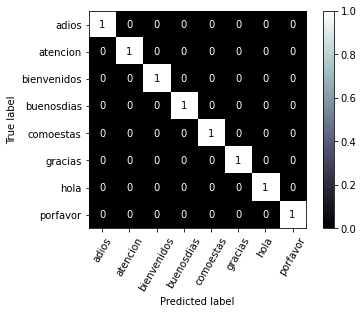

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
   y_test_lab, y_pred_lab, normalize='true', cmap='bone', xticks_rotation=60)

plt.show()

### Real Time Test

In [18]:
''' ORIGINAL '''

len_videos = 30
video_frames = []
sign_sequence = []
confidence = 0.9
model_6signs.load_weights('models/8S-3_v2.h5')
signs = np.array(["hola", "gracias", "atencion", "comoestas", "buenosdias", "bienvenidos","adios", "porfavor"])
# signs = np.array(["hola", "gracias", "atencion"])
# model = load_model("models/model_6signs_2000ep_v2.h5")
model = model_6signs
out = cv2.VideoWriter('output.mp4', -1, 20.0, (640,480))

camera = cv2.VideoCapture(1)

if camera.isOpened() is False: print("Camera is not available.")
    
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic: # Setting mediapipe model
    while camera.isOpened():
        for num_frame in range(len_videos):
            # Read frames and show them
            _, frame = camera.read()

            # Model results prediction
            img, results = detection(frame, holistic)

            # Show landmarks
            show_landmarks(img, results)

            # Predictions
            landmarks = get_landmarks(results)
            video_frames.append(landmarks)
            video_frames = video_frames[-30:]

            if num_frame == 0:
                cv2.putText(img, 'Comenzando captura', (100,200), cv2.FONT_HERSHEY_SIMPLEX, .75, (0,0,255), 1, cv2.LINE_AA)
                
                cv2.imshow('Sign Language Recognition', img)
                cv2.waitKey(1000) # Wait 2sec
            else:
                if num_frame == len_videos - 1:
                    pred = model.predict(np.expand_dims(video_frames, axis=0))[0]
                    sign_pred = signs[np.argmax(pred)]
                    

                    if len(sign_sequence) > 0:
                        if sign_pred != sign_sequence[-1]:
                            sign_sequence.append(sign_pred)
                    else:
                        sign_sequence.append(sign_pred)

                if len(sign_sequence) > 4:
                    sign_sequence = sign_sequence[-4:]
                cv2.rectangle(img, (0,0), (640, 40), (255, 255, 255), -1)
                cv2.putText(img, ' '.join(sign_sequence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, .75, (0,0,0), 1, cv2.LINE_AA)
                cv2.imshow('Sign Language Recognition', img)

            out.write(img)

            if cv2.waitKey(1) == ord("q"):
                camera.release()
                break
    out.release()
    cv2.destroyAllWindows()

In [24]:
''' TEST '''
'''
len_videos = 30
video_frames = []
sign_sequence = []
confidence = 0.9
model_3signs.load_weights('models/3S-2.h5')
# signs = np.array(["hola", "gracias", "atencion", "comoestas", "buenosdias", "bienvenidos","adios", "porfavor"])
signs = np.array(["hola", "gracias", "atencion"])
# model = load_model("models/model_6signs_2000ep_v2.h5")
model = model_3signs
out = cv2.VideoWriter('output.mp4', -1, 20.0, (640,480))

camera = cv2.VideoCapture(1)

if camera.isOpened() is False: print("Camera is not available.")
    
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic: # Setting mediapipe model
    while camera.isOpened():
        for num_frame in range(len_videos):
            # Read frames and show them
            _, frame = camera.read()

            # Model results prediction
            img, results = detection(frame, holistic)

            # Show landmarks
            show_landmarks(img, results)

            # Predictions
            landmarks = get_landmarks(results)
            video_frames.append(landmarks)
            video_frames = video_frames[-30:]
            
            if len(video_frames) == 30:
                pred = model.predict(np.expand_dims(video_frames, axis=0))[0]
                sign_pred = signs[np.argmax(pred)]
        
                if pred[np.argmax(pred)] > confidence:
                    if len(sign_sequence) > 0:
                        if sign_pred != sign_sequence[-1]:
                            sign_sequence.append(sign_pred)
                    else:
                        sign_sequence.append(sign_pred)

            if len(sign_sequence) > 4:
                sign_sequence = sign_sequence[-4:]
                
                
            img = show_probabilities(pred, signs, img, colors)
            cv2.rectangle(img, (0,0), (640, 40), (255, 255, 255), -1)
            cv2.putText(img, ' | '.join(sign_sequence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, .75, (0,0,0), 1, cv2.LINE_AA)
            cv2.imshow('Sign Language Recognition', img)


            if cv2.waitKey(1) == ord("q"):
                camera.release()
                break
    out.release()
    cv2.destroyAllWindows()
    '''

In [22]:
colors = [(245,117,16),(117,245,16),(16,117,245)]
def show_probabilities(pred, signs, img, colors):
    output = img.copy()
    for index, prob in enumerate(pred):
        cv2.rectangle(output, (0,60+index*40), (int(prob*100), 90+index*40), colors[index], -1)
        cv2.putText(output, signs[index], (0, 85+index*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output

In [23]:
plt.imshow(show_probabilities(results, signs, img, colors))

TypeError: 'type' object is not iterable